In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools as it
import scipy.linalg, scipy.optimize
from scipy.linalg import expm
import copy as cp

# Hamiltonian of the Schwinger model:
Consider the purely fermionic formulation and open boundary condition (OBC), the dimensionless Hamiltonian is:
$$    H = \text{x}\sum_{x=0}^{N-2}{\left[\psi^\dagger(x)\psi(x+1)+\text{h.c.}\right]} + \mu \sum_{x=0}^{N-1}{(-1)^x\psi^\dagger(x)\psi(x)} + \sum_{x=0}^{N-2}{\left\{ \epsilon_0-\sum_{y=0}^x{\left[\psi^\dagger(y)\psi(y)-\frac{1-{(-1)}^y}{2}\right]} \right\}^2} $$
The hopping term, the mass term and the electric term in the electric basis are still recognizable, but only fermionic operators $\psi$, $\psi^\dagger$ remain. After Jordan-Wigner transformation, one obtains:
$$
    H =  \text{x}\sum_{x=0}^{N-2}{\left[\sigma^+(x)\sigma^-(x+1)+\text{h.c.}\right]} + \frac{\mu}{2} \sum_{x=0}^{N-1}{(-1)^{x+1}\sigma^{\text{z}}(x)} + \sum_{x=0}^{N-2}{\left\{ \epsilon_0+ \frac{1}{2}\sum_{y=0}^x{\left[\sigma^{\text{z}}(y)-(-1)^y\right]} \right\}^2} 
    =  H^X + H^{ZZ} + H^Z
$$
The goal of this notebook is to study the dyamics of Schwinger model using exact diagonalization. 

### Theory parameters

In [2]:
N = 4          # number of sites
a = 1          # lattice spacing

Nphys = N//2   # number of physical sites
x_factor = 0.6 # hopping parameter
mf = 0.1       # fermion mass
pi = math.pi

In [3]:
Hilbert_full = 2**N
print("Size of full Hilbert space =", Hilbert_full)

Size of full Hilbert space = 16


In [4]:
# General functions
def commute(A,B):
    res = np.matmul(A,B) - np.matmul(B,A)
    return(np.all(np.isclose(res,0)))

def is_hermitian(H):
    HC = H.conj().T
    return(np.all(np.isclose(HC, H)))

def eigen(H):
    Hw, Hv =  scipy.linalg.eigh(H)
    idx = Hw.argsort() #small to large
    Hw = Hw[idx].real
    Hv = Hv.T
    Hv = Hv[idx]
    return Hw, Hv

# Full Hilbert space Hamiltonian

In [5]:
# Define the Pauli matrices
I = np.array([[1, 0], [0, 1]], dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)

# tensor product
def kron_n(*args):
    """Computes the Kronecker product of a list of matrices."""
    result = np.array([[1]], dtype=complex)
    for op in args:
        result = np.kron(op, result)
    return result

### Build the Hamiltonian using spin operators

In [6]:
e0 = 0
I_mat = kron_n(*[I for k in range(N)])

# 2 ways of implementing H_x (hopping term)

# "Stairs" (V_1')
H_xx = np.zeros((2**N, 2**N), dtype=complex)
for i in range(N-1):
    spins_x = [X if j == i or j == (i + 1) % N else I for j in range(N)]
    H_xx += 0.5 * kron_n(*spins_x)
    
H_yy = np.zeros((2**N, 2**N), dtype=complex)    
for i in range(N-1):
    spins_y = [Y if j == i or j == (i + 1) % N else I for j in range(N)]
    H_yy += 0.5 * kron_n(*spins_y)

H_x_stairs = H_xx + H_yy

# "Brickwall" (V_1)
H_x_even = np.zeros((2**N, 2**N), dtype=complex)
for i in range(0, N-1, 2):
    spins_x = [X if j == i or j == (i + 1) % N else I for j in range(N)]
    spins_y = [Y if j == i or j == (i + 1) % N else I for j in range(N)]
    H_x_even += 0.5 * (kron_n(*spins_x)+kron_n(*spins_y))
    
H_x_odd = np.zeros((2**N, 2**N), dtype=complex)    
for i in range(1, N-2, 2):
    spins_x = [X if j == i or j == (i + 1) % N else I for j in range(N)]
    spins_y = [Y if j == i or j == (i + 1) % N else I for j in range(N)]
    H_x_odd += 0.5 * (kron_n(*spins_x)+kron_n(*spins_y))
    

H_x_brickwall = H_x_even + H_x_odd
    
print(np.all(np.isclose(H_x_stairs, H_x_brickwall)))

True


In [7]:
# mass term
H_z = np.zeros((2**N, 2**N), dtype=complex)
for i in range(N):
    spins = [Z if j == i else I for j in range(N)]
    H_z += (-1)**(i+1)*kron_n(*spins)

# electric term, notice the non-local stucture
H_zz = np.zeros((2**N, 2**N), dtype=complex)
for i in range(N-1):
    E_mat = np.zeros((2**N, 2**N), dtype=complex)
    for j in range(i+1):
        spins = [Z if k == j else I for k in range(N)]
        E_mat += 0.5*(kron_n(*spins) - (-1)**j*I_mat)
    H_zz += (e0*I_mat + E_mat) @ (e0*I_mat + E_mat)

In [8]:
# Check commute or not
print(commute(H_zz, H_x_brickwall))
print(commute(H_zz, H_z))

False
True


### Spectrum of the full Hamiltonian

In [9]:
H_full = x_factor*H_x_brickwall + 0.5*mf*H_z + H_zz
print(H_full.shape)

(16, 16)


In [10]:
Hw, Hv = eigen(H_full)
print("Spectrum =")
print(Hw)

Spectrum =
[-0.84487809 -0.55591798  0.62550611  0.7470235   0.88259793  1.
  1.34238256  1.40926326  1.9913733   2.          2.26405679  2.34697392
  3.17141253  3.40849811  6.          6.21170807]


# Time evolution

To study the dynamics, we directly construct the time-evolution operator $U = e^{-iHt}$ by exactly exponentiating the Hamiltonian.

In [11]:
# Time evolution operator U(t) = exp(-i * H * t)
def time_evolution(H, t):
    return expm(-1j * H * t)

The initial state is set to be the strong coupling vacuum $|\psi(0)> = {|01>}^{\otimes N/2}$. Here we are interested in the survival probability of the vacuum at time $t$:
$$
P_{\rm vac}(t) = {\left|<\psi(0)|\psi(t)>\right|}^2 = {\left|<\psi(0)|e^{-iHt}|\psi(0)>\right|}^2
$$
Using the following parameters, one should be able to recover fig.6 in 2112.14262. 

In [12]:
# Parameters for time evolution
time_steps = 100
total_time = 5
delta_t = total_time / time_steps

# Initial state |1010>
initial_state = np.zeros(2**N, dtype=complex)
initial_state[10] = 1.0

In [13]:
# Evolve the state over time
state = initial_state.copy()
evolution = [state]
for step in range(time_steps):
    U = time_evolution(H_full, delta_t)
    state = U @ state
    evolution.append(state)
# Print final evolved state (amplitude squared)
print("Final state (amplitude squared):")
print(np.abs(state)**2)

Final state (amplitude squared):
[0.         0.         0.         0.00312552 0.         0.00162288
 0.12517595 0.         0.         0.12517595 0.45106123 0.
 0.29383847 0.         0.         0.        ]


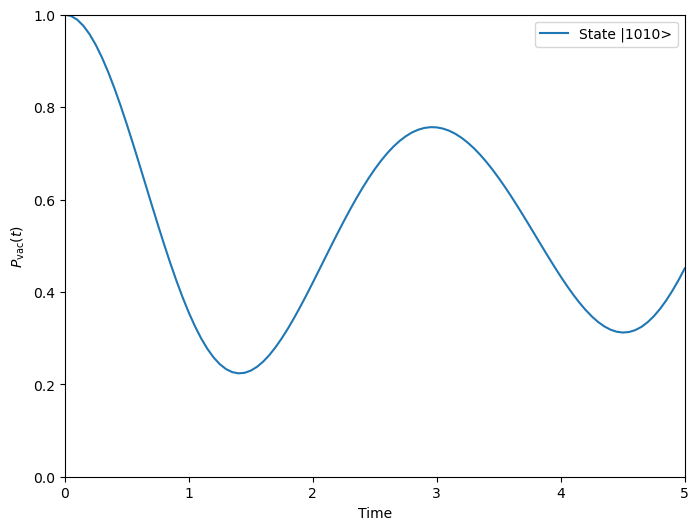

In [14]:
# Plot probabilities
probabilities = [np.abs(state)**2 for state in evolution]
times = np.linspace(0, total_time, time_steps + 1)
plt.figure(figsize=(8,6))
plt.plot(times, [prob[10] for prob in probabilities], label=f"State |1010>")
plt.ylim(0,1)
plt.xlim(0,total_time)
plt.xlabel("Time")
plt.ylabel(r"$P_{\rm vac}(t)$")
plt.legend()
plt.show()

The exact-diagonalization result serves as a benchmark for your circuit. Now you need to do the following:
1. Figure out the coefficients of all ZZ and Z operators in the Hamiltonian, and use them as the angles for your gates.
2. Implement 10 Trotter steps for the circuit time-evolution ($\delta t$ for each step = 0.5). Use $V_1$ ordering (brickwall $H_x$). Plot the Trotterized survival probability.


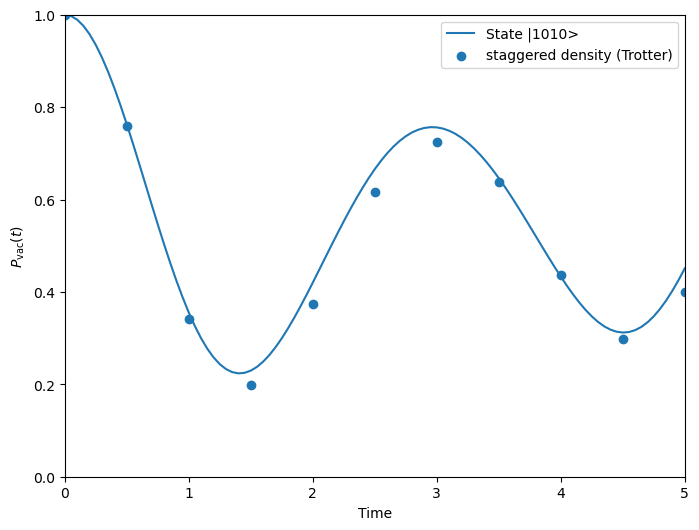

In [15]:
# Plot probabilities
N_trotter = 10

# Your circuit result
#p_vac_trotter = [1.,         0.76021808, ...]

plt.figure(figsize=(8,6))
plt.plot(times, [prob[10] for prob in probabilities], label=f"State |1010>")
plt.scatter(np.linspace(0, total_time, N_trotter + 1), p_vac_trotter, label="staggered density (Trotter)")
plt.ylim(0,1)
plt.xlim(0,total_time)
plt.xlabel("Time")
plt.ylabel(r"$P_{\rm vac}(t)$")
plt.legend()
plt.show()

Compare your results with fig.6 in 2112.14262

# Appendix

Here are some additional checks one can perform, including:
1. Check the spectrum of the physical Hamiltonian with OBC
2. Apply exact exponentiation of different components in the Hamiltonian. This should match the circuit result
3. Calculate the staggered density using ED and Trotter

The staggered density counts the fermionic excitation, and is defined as:
$$
\nu(t) = \frac{1}{N}\sum_n{\nu_n(t)} \\
\nu_n(t) = <\psi(t)|\frac{(-1)^{(n+1)}\sigma_n^{\rm z}+1}{2}|\psi(t)>
$$